In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import re, string, unicodedata
import nltk
import contractions
import inflect

import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer

import re

from wordcloud import WordCloud, STOPWORDS

import nltk
# import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer


from sklearn import metrics
from sklearn.model_selection import train_test_split
# from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
%matplotlib inline

import scipy

from gensim import corpora
from gensim import corpora
from gensim.similarities.docsim import Similarity
from gensim import corpora, models, similarities

import pickle
import time

## Read Train Split and Validation Data

In [14]:
# sys_path = "/Users/sigao/Yelp/yelp_dataset/"
## Reviews
rev_busi_Pho= pd.read_csv('../data/filtered_reviews_in_Phonex.csv', parse_dates=["date"])
## Read training and test sets
train_df  = pickle.load(open('../data/train_df.pkl', "rb"))
# valid_df.to_pickle('../data/valid_df.pkl')
test_df = pickle.load(open('../data/test_df.pkl', "rb"))

In [15]:
rev_busi_Pho.head(1)

,Unnamed: 0,review_id,user_id,business_id,stars,date,text,business_name,city,state,categories
0,1,aBWKb49Xfkv1946YN7_SIg,sSPbLBHcEMXaJfoO8zs1bA,poSV39UqEg-gpESXafS9-g,5.0,2016-01-17 05:33:14,"Amazing food, drinks, service!\n\nWe started w...",Angry Crab Shack,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr..."


In [16]:
## merge review data:
train_df = train_df.merge(rev_busi_Pho[["review_id", "user_id", "business_id", "text"]], how = "left", on = ["user_id", "business_id"])
test_df  = test_df.merge(rev_busi_Pho[["review_id", "user_id", "business_id", "text"]], how = "left", on = ["user_id", "business_id"])
print(train_df.shape)
print(test_df.shape)

(217228, 5)
(20433, 5)


In [6]:
train_df.head(1)

,user_id,business_id,stars,review_id,text
0,--2HUmLkcNHZp0xw6AMBPg,zidkKI_N1OPxsiddTOQH_Q,5.0,CqP0d_bAjPOjHtte5gTSvg,Good BBQ in the valley. Nice selection of sau...


In [17]:
print("unique users in training set:", train_df["user_id"].nunique() )
print("unique businesses in training set:", train_df["business_id"].nunique() )
print("unique users in test set:", test_df["user_id"].nunique() )
print("unique businesses in test set:", test_df["business_id"].nunique())

unique users in training set: 20472
unique businesses in training set: 1781
unique users in test set: 20433
unique businesses in test set: 1101


## Content-based Model, NLP

### Collate texts for each business for training and test sets

In [18]:
# reviews_subset["review_count2"] = reviews_subset.groupby("business_id")["review_id"].transform(len)
df_revtexts_train = train_df.groupby(["business_id"])["text"].apply(lambda x: x.str.cat()).reset_index()
print(len(df_revtexts_train))
df_revtexts_train
## test set :
# df_revtexts_test = test_df.groupby(["business_id"])["text"].apply(lambda x: x.str.cat()).reset_index()
# print(len(df_revtexts_test))

1781


,business_id,text
0,-050d_XIor1NpCuWkbIVaQ,Great Food. Great Coffee. Great Service. Amazi...
1,-0WegMt6Cy966qlDKhu6jA,I really enjoy a well placed sports bar...lite...
2,-0tgMGl7D9B10YjSN2ujLA,Neighborhood bar. Comfortable and reasonable i...
3,-1UMR00eXtwaeh59pEiDjA,Well I say they're doing a great job transform...
4,-45kMvS7h38CGaWugPY0rg,Roland's was developed by Chris Bianco from Pi...
...,...,...
1776,zc1sur_MxkKkD6P8gYXQbg,Food was good and the price was right. We almo...
1777,zidkKI_N1OPxsiddTOQH_Q,Good BBQ in the valley. Nice selection of sau...
1778,znH36RmIAI4wcHy9WiEO5Q,I had a great experience at this relatively ne...
1779,zrTGcb83AsfyVTMrsCa65A,It's not bad. It's not great either. Came last...


### Generate Wordcloud

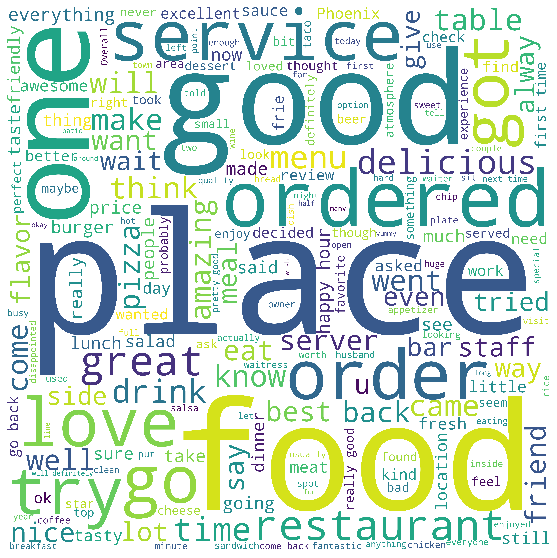

In [13]:
all_text = ""
all_snippets = df_revtexts_train["text"].values
for snippet in all_snippets:
    all_text += snippet
wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=6000,height=6000).generate(all_text)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Test Prepocessing

In [19]:
## Util functions
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_special(words):
    """Remove special signs like &*"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[-,$()#+&*]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""  
    stopwords = nltk.corpus.stopwords.words('english')
    myStopWords = []
    stopwords.extend(myStopWords)
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def to_lowercase(words):
    """Convert words to lowercase"""
    new_words=[]
    for word in words:
        new_words.append(word.lower())
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stemmer = SnowballStemmer('english')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize_lemmatize(words):
    words = remove_special(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

In [20]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
def get_processed(sample):
    processed = pd.DataFrame(data=[],columns = ['business_id', 'text'])
    new_texts = []

    for i in range(0, len(sample)):
        business_id = sample['business_id'].iloc[i]
        words = nltk.word_tokenize(sample['text'].iloc[i])
        text = ' '.join(normalize_lemmatize(words))
        dfnew = pd.DataFrame([[business_id, text]], columns=['business_id', 'text'])
        new_texts.append(text)
        processed = processed.append(dfnew,ignore_index = True)
    return processed

[nltk_data] Downloading package wordnet to /Users/xli/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /Users/xli/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /Users/xli/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
df_texts_train = get_processed(df_revtexts_train)
# df_texts_test = get_processed(df_revtexts_test)
df_texts_train.to_pickle('../data/df_texts_train.pkl')

## Cosine Similarity

In [49]:
def get_tfidf_matrix(processed):
    TV = TfidfVectorizer(stop_words = "english")
    processed["text"] = processed["text"].fillna('')
    tfidf_matrix = TV.fit_transform((processed["text"]))
    return tfidf_matrix

def get_cos_sim_matrix(tfidf_matrix, n):
    ## use truncated SVD to reduce dimensions
    SVD = TruncatedSVD(n_components = n , random_state = 42) # 42 is the ultimate answer to everything
    tfidf_truncated = SVD.fit_transform(tfidf_matrix)
    cosine_sim = cosine_similarity(tfidf_truncated, tfidf_truncated)
    return cosine_sim

<BarContainer object of 1780 artists>

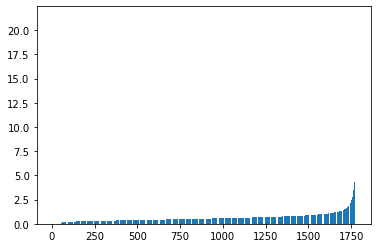

In [203]:
## Choose the number of singular values to truncate the sparse tfidf matrix:
tfidf_matrix = get_tfidf_matrix(df_texts_train)
u, s, vt  = scipy.sparse.linalg.svds(tfidf_matrix, k = tfidf_matrix.shape[0]-1)
plt.bar(range(len(s)),s)


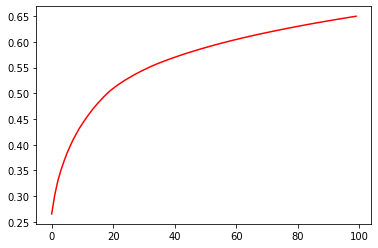

In [270]:
# plt.bar(range(len(s))[:100], sorted((s**2 / sum(s**2)),reverse = True)[:100])
plt.plot(range(len(s))[:100], np.cumsum(sorted((s**2 / sum(s**2)),reverse = True)[:100]), "r" )

## *Based on the above plot, we choose the first 20 singular values, i.e. n = 20 

In [214]:
tfidf_matrix = get_tfidf_matrix(df_texts_train)
cosine_sim = get_cos_sim_matrix(tfidf_matrix, 20)
df_sim = pd.DataFrame(cosine_sim, index=df_texts_train['business_id'], columns=df_texts_train['business_id'])
cosine_sim.shape

(1781, 1781)

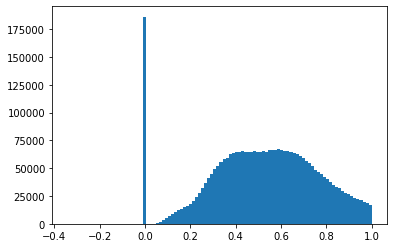

In [215]:
plt.figure()
plt.hist(cosine_sim.flatten(), bins = 100)
plt.show()

In [242]:
def get_recommendation_cos(reviews, business_id, user_id, df_sim, k):
#     df_sim = pd.DataFrame(cosine_sim, index=processed['business_id'], columns=processed['business_id'])
    user_bids = reviews[reviews['user_id']==user_id]['business_id'].values
    df_user = df_sim.loc[df_sim.index.isin(user_bids), df_sim.columns == business_id]
    df_user_topk = df_user.sort_values(df_user.columns[0], ascending = False).iloc[:k]
    return np.array(df_user_topk.index.values)

def get_results_cos(reviews, reviews_test, business_id,user_id,df_sim,k):
    actual = reviews_test.loc[(reviews_test.user_id==user_id) & (reviews_test.business_id==business_id)]['stars'].values[0]
    business_ids = get_recommendation_cos(reviews,business_id,user_id,df_sim,k)
#     print(business_ids)
    prediction = predict_rating(reviews, user_id, business_ids)
    return actual, prediction

# def get_review_processed(processed, reviews):
#     reviews_processed = reviews.loc[reviews.business_id.isin(processed.business_id)]\
#                            .reset_index().drop(columns=['index'])
#     return reviews_processed

In [22]:
def predict_rating(reviews, user_id, business_ids):
    scores = reviews.loc[(reviews.user_id == user_id) & (reviews.business_id.isin(business_ids))]["stars"].values
    return np.mean(scores)

In [268]:
### Now collate the modelling into a function left with parameters to tune:

# parameters: n (top n singular values to perform truncated SVD), k (top k similar businesses) 
def CB_NLP_cosine(train_df, reviews, n = 20):
    tfidf_matrix = get_tfidf_matrix(reviews)
    cosine_sim = get_cos_sim_matrix(tfidf_matrix, n)
    df_sim = pd.DataFrame(cosine_sim, index=df_texts_train['business_id'], columns=df_texts_train['business_id'])
    return df_sim

def CB_NLP_predict(reviews, reviews_test, df_sim, k = 5):
    uid_sample = reviews_test['user_id'].values
    bid_sample = reviews_test['business_id'].values
    actual_cos = []
    predictions_cos = []
    for i in range(len(reviews_test)):
        try:
            act, pred = get_results_cos(reviews, reviews_test, bid_sample[i],uid_sample[i], df_sim, k)
            predictions_cos.append(pred)
            actual_cos.append(act)
        except:
            predictions_cos.append(np.nan)
            actual_cos.append(np.nan)
#     print(actual_cos)
    return pd.DataFrame({"user_id": uid_sample,
                         "business_id": bid_sample,
                         "ratings": actual_cos,
                         "pred":  predictions_cos                        
                        })

### Tuning parameters k

In [321]:
t0 = time.time()
df_pred_results = pd.DataFrame(columns= ["ks", "sample_size", "rmse", "mae"])
sample_sizes = [len(test_df)]
ks = [5,10,15,20,30,40]

for sample_size in sample_sizes:
    for k in ks:
        test = CB_NLP_predict(train_df, test_df.sample(n = sample_size, random_state = 12), df_sim, k)
        rmse = mean_squared_error(test.dropna().pred, test.dropna().ratings)**0.5
        mae = mean_absolute_error(test.dropna().pred, test.dropna().ratings)**0.5
        df_pred_results = df_pred_results.append({"ks": k, "sample_size": sample_size,
                                "rmse": rmse, "mae": mae           
        }, ignore_index = True)

t1=  time.time()
print("time elapsed: (seconds)")
print(np.round(t1- t0,3))

time elapsed: (seconds)
5591.132


optimal k (nearest neighbors):
4    30.0
Name: ks, dtype: float64


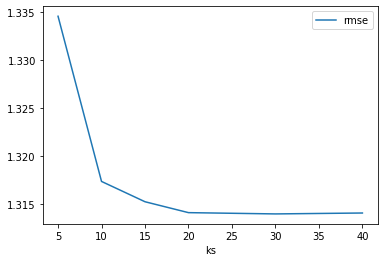

In [326]:
df_pred_results[df_pred_results["sample_size"] == sample_size].plot("ks", "rmse")
print("optimal k (nearest neighbors):")
print(df_pred_results.loc[df_pred_results["rmse"] == np.min(df_pred_results.rmse) ,"ks"])
# choose 30?


In [323]:
df_pred_resultsults.to_csv("Content_Based_Filtering_Cosine_Evaluation.csv",index = False)

## LSI Model

#### 2 parameters to tune: n_topics and k nearest businesses

In [ ]:
#### Dont run this cell !!!

def get_lsi(processed, reviews, user_id, n_topics):
    user_bids = reviews[reviews['user_id']==user_id]['business_id'].values
    processed_user = processed.loc[processed.business_id.isin(user_bids)]
    documents = list(processed_user['text'].values)
    texts = [[word for word in document.split(' ')] for document in documents]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts] 

    lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=n_topics)
    return lsi, dictionary, corpus

df_lsi = pd.DataFrame(columns = ["user_id","n_topic", "lsi", "dictionary"])
n_topics = [10,20,50,80,100,150]

for n_topic in n_topics:
#     count = 0 
    for i in range(len(test_df)):
#         print(i) 
#         count += 1
        lsi, dictionary, corpus = get_lsi(df_texts_train, train_df, uid_sample[i], n_topic)
        df_lsi = df_lsi.append({"user_id": test_df.user_id[i],
                            "n_topic": n_topic,
                            "lsi": lsi,
                            "dictionary": dictionary
                           }, ignore_index = True)
#         if count >= 3:
#             break

def get_recommendation_lsi(processed,reviews, df_lsi, business_id,user_id,k,n_topics):
#     user_bids = reviews[reviews['user_id']==user_id]['business_id'].values
#     processed_user = processed.loc[processed.business_id.isin(user_bids)]
#     documents = list(processed_user['text'].values)
#     texts = [[word for word in document.split(' ')] for document in documents]
#     dictionary = corpora.Dictionary(texts)
#     corpus = [dictionary.doc2bow(text) for text in texts] 
    
    lsi = df_lsi[(df_lsi["n_topic"] == n_topics) & (df_lsi["user_id"] == user_id)]["lsi"][0]
    dictionary = df_lsi[(df_lsi["n_topic"] == n_topics) & (df_lsi["user_id"] == user_id)]["dictionary"][0]


    user_bids = reviews[reviews['user_id']==user_id]['business_id'].values
    processed_user = processed.loc[processed.business_id.isin(user_bids)]
    documents = list(processed_user['text'].values)
    texts = [[word for word in document.split(' ')] for document in documents]
    corpus = [dictionary.doc2bow(text) for text in texts] 
    
    #     lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=n_topics)
    doc = processed['text'].loc[processed.business_id==business_id].values[0]
    vec_bow = dictionary.doc2bow(doc.lower().split())
    vec_lsi = lsi[vec_bow]
    index = similarities.MatrixSimilarity(lsi[corpus])
    sims = list(index[vec_lsi])
    results = list(zip(user_bids, sims))
    results_ordered = np.array(sorted(results, key=lambda x: x[1], reverse=True))
    results_topk = results_ordered[:k]
    return results_topk[:,0]

def get_results_lsi(processed,reviews,reviews_test, df_lsi ,business_id,user_id,k,n_topics):
    actual = reviews_test.loc[(reviews_test.user_id==user_id) & (reviews_test.business_id==business_id)]['stars'].values[0]
    business_ids = get_recommendation_lsi(processed,reviews,df_lsi ,business_id,user_id,k,n_topics)
    prediction = predict_rating(reviews, user_id, business_ids)
    return actual, prediction



In [ ]:
def get_recommendation_lsi(processed,reviews,business_id,user_id,k,n_topics):
    user_bids = reviews[reviews['user_id']==user_id]['business_id'].values
    processed_user = processed.loc[processed.business_id.isin(user_bids)]
    documents = list(processed_user['text'].values)
    texts = [[word for word in document.split(' ')] for document in documents]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts] 

    lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=n_topics)
    doc = processed['text'].loc[processed.business_id==business_id].values[0]
    vec_bow = dictionary.doc2bow(doc.lower().split())
    vec_lsi = lsi[vec_bow]
    index = similarities.MatrixSimilarity(lsi[corpus])
    sims = list(index[vec_lsi])
    results = list(zip(user_bids, sims))
    results_ordered = np.array(sorted(results, key=lambda x: x[1], reverse=True))
    results_topk = results_ordered[:k]
    return results_topk[:,0]

def get_results_lsi(processed,reviews,reviews_test ,business_id,user_id,k,n_topics):
    actual = reviews_test.loc[(reviews_test.user_id==user_id) & (reviews_test.business_id==business_id)]['stars'].values[0]
    business_ids = get_recommendation_lsi(processed,reviews,business_id,user_id,k,n_topics)
    prediction = predict_rating(reviews, user_id, business_ids)
    return actual, prediction

# def get_coverage_lsi(processed,reviews,n_topics):
#     reviews_processed = get_review_processed(processed, reviews)
#     uid_sample = reviews_processed['user_id'].values
#     bid_sample = reviews_processed['business_id'].values
#     all_bids = reviews_processed['business_id'].unique()
#     pred_bids = []

#     for i in range(len(reviews_processed)):
#         try:
#             business_ids = get_recommendation_lsi(processed,
#                                             reviews_processed,
#                                             bid_sample[i],
#                                             uid_sample[i],
#                                             5,
#                                             n_topics)
#             pred_bids += list(business_ids)
#         except:
#             next
#     pred_bids = np.array(list(set(pred_bids)))
#     return len(pred_bids)/len(all_bids)

In [ ]:
def CB_LSI_predict(df_texts_train, reviews, reviews_test, k = 5, n_topics = 100):
    uid_sample = reviews_test['user_id'].values
    bid_sample = reviews_test['business_id'].values
    actual_lsi = []
    predictions_lsi = []
    for i in range(len(reviews_test)):
        try:
            act, pred = get_results_lsi(df_texts_train, reviews, reviews_test, bid_sample[i],uid_sample[i], k, n_topics)
            predictions_lsi.append(pred)
            actual_lsi.append(act)
#             print(act)
#             print(pred)
        except:
            predictions_lsi.append(np.nan)
            actual_lsi.append(np.nan)
#     print(actual_cos)
    return pd.DataFrame({"user_id": uid_sample,
                         "business_id": bid_sample,
                         "ratings": actual_lsi,
                         "pred_lsi":  predictions_lsi                       
                        })

In [ ]:
t0 = time.time()
df_pred_results_lsi = pd.DataFrame(columns= ["ks","n_topics","sample_size", "rmse", "mae"])
# sample_sizes = [100]
ks = [40]
n_topics = [20,50,80,100]

# for sample_size in sample_sizes:
for k in ks:
    for n_topic in n_topics:
        test = CB_LSI_predict(df_texts_train,train_df, test_df, k = k, n_topics = n_topic)
        rmse = mean_squared_error(test.dropna().pred_lsi, test.dropna().ratings)**0.5
        mae = mean_absolute_error(test.dropna().pred_lsi, test.dropna().ratings)**0.5
        df_pred_results_lsi = df_pred_results_lsi.append({"ks": k, "n_topics": n_topic,"sample_size": len(test_df),
                                "rmse": rmse, "mae": mae}, ignore_index = True)
t1=  time.time()
print("time elapsed: (seconds)")
print(np.round(t1- t0,3))

In [58]:
df_pred_results_lsi

,ks,n_topics,sample_size,rmse,mae
0,40.0,20.0,20433.0,1.165239,0.914670
1,40.0,50.0,20433.0,1.165827,0.915209
2,40.0,80.0,20433.0,1.166328,0.915811
3,40.0,100.0,20433.0,1.166328,0.915811


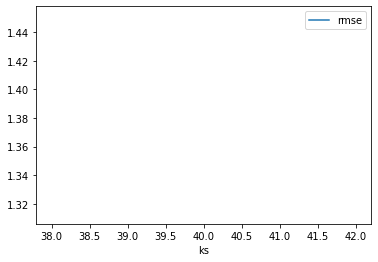

In [90]:
df_pred_results_lsi[df_pred_results_lsi["n_topics"] == 120].plot("ks", "rmse")


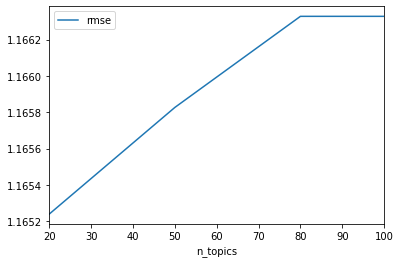

In [59]:
df_pred_results_lsi[df_pred_results_lsi["ks"] == 40].plot("n_topics", "rmse")

In [349]:
mean_squared_error(test.dropna().pred_lsi, test.dropna().ratings)**0.5

0.0

In [333]:
df_pred_results_lsi

,ks,n_topics,sample_size,rmse,mae
0,10.0,10.0,50.0,0.0,0.0
1,10.0,50.0,50.0,0.0,0.0
2,10.0,100.0,50.0,0.0,0.0
3,10.0,200.0,50.0,0.0,0.0


In [34]:
%timeit get_results_lsi(df_texts_train, train_df, test_df, bid_sample[0], uid_sample[0], 30,10)

651 ms ± 37.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
# experiement
uid_sample = test_df['user_id'].values
bid_sample = test_df['business_id'].values
act, pred = get_results_lsi(df_texts_train, train_df, 
                                test_df, 
                                bid_sample[0], 
                                uid_sample[0], 
                                30,
                                20)

In [54]:
act, pred

(5.0, 4.633333333333334)